In [1]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu
import anndata
#import scvelo as scv

import numpy as np
import mplscience

In [2]:
adata = anndata.read_h5ad("/home/lab401_B/scRNA_downstream/cellrank/scRNA_pig_oogenesis/Pig_ovary_granulosa_final.h5ad")
#scv.pl.proportions(adata)
adata

AnnData object with n_obs × n_vars = 3774 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [3]:
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 3774 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

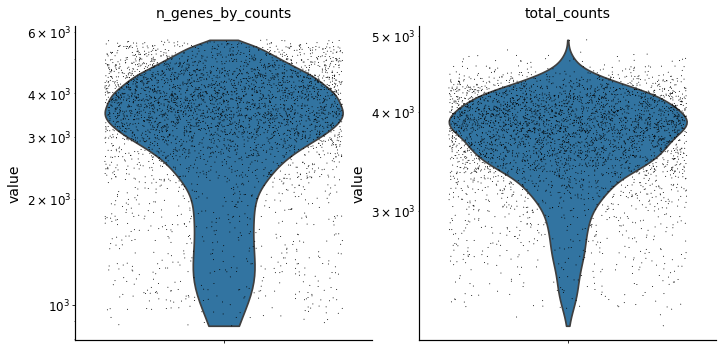

In [5]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
                jitter=0.4, multi_panel=True, log=True)

In [6]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

In [7]:

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)

In [8]:
adata.layers["log_normalized"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 3738 × 16787
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'log1p'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

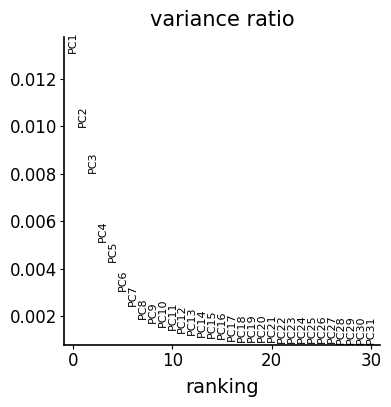

In [9]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata)

In [10]:
# rerun with fewer components
sc.tl.pca(adata, n_comps=10)

In [11]:
adata

AnnData object with n_obs × n_vars = 3738 × 16787
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'log1p'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

In [12]:
adata.layers["counts"]

<3738x16787 sparse matrix of type '<class 'numpy.float32'>'
	with 13231630 stored elements in Compressed Sparse Row format>

In [13]:
import scipy
adata.layers["counts"]=scipy.sparse.csc_matrix(adata.layers["counts"])
adata.layers["counts"]

<3738x16787 sparse matrix of type '<class 'numpy.float32'>'
	with 13231630 stored elements in Compressed Sparse Column format>

In [14]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata.layers["counts_csc"] = adata.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [15]:
hs_results = hs.compute_autocorrelations(jobs=10)

hs_results.head(15)

100%|██████████████████████████████████████████████████████████████| 16787/16787 [00:26<00:00, 639.73it/s]


C           Z  Pval  FDR
Gene                                         
ISG12(A)      0.910178  245.712614   0.0  0.0
IFI6          0.906739  242.326955   0.0  0.0
ISG15         0.861317  228.845765   0.0  0.0
MX1           0.806114  214.999806   0.0  0.0
SLA-2         0.801756  207.471221   0.0  0.0
B2M           0.697473  181.003763   0.0  0.0
OSR1          0.689290  179.954658   0.0  0.0
CCDC80        0.703214  178.625964   0.0  0.0
PNLIPRP2      0.666263  172.084829   0.0  0.0
DAPL1         0.643479  169.153444   0.0  0.0
IGF2          0.625204  168.602948   0.0  0.0
LTBP4         0.577638  166.176809   0.0  0.0
PLAC8         0.611179  162.118922   0.0  0.0
RN18S         0.753367  160.512109   0.0  0.0
LOC100626247  0.743224  160.297028   0.0  0.0

In [16]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=10)

Computing pair-wise local correlation on 500 features...


100%|███████████████████████████████████████████████████████████| 124750/124750 [00:24<00:00, 5132.41it/s]


In [48]:
modules = hs.create_modules(
    min_gene_threshold=10,   ## 数值增加会减少 module 数量
    core_only=True, fdr_threshold=0.05 
)

modules.value_counts()

-1     68
 1     63
 2     54
 5     35
 3     34
 6     29
 13    28
 7     27
 10    24
 8     18
 15    17
 12    15
 11    15
 9     14
 16    13
 18    12
 4     12
 14    12
 17    10
Name: Module, dtype: int64

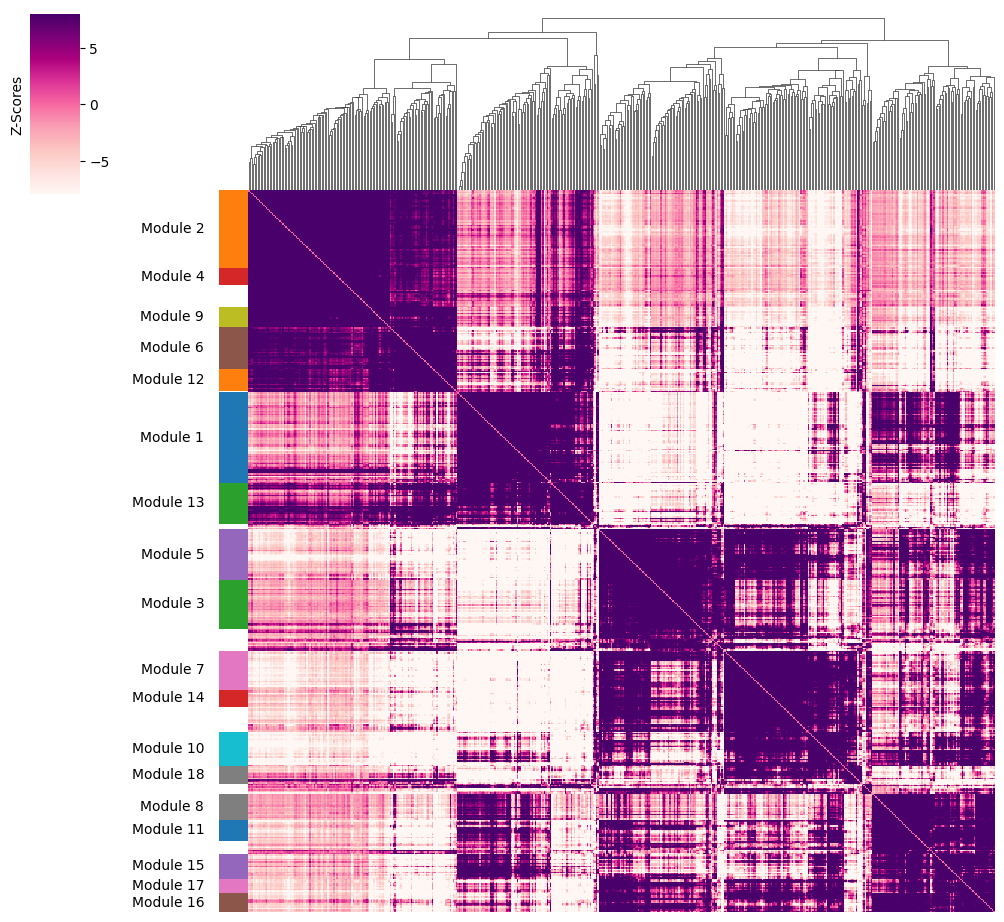

In [49]:
hs.plot_local_correlations(z_cmap='RdPu')
# viridis; magma

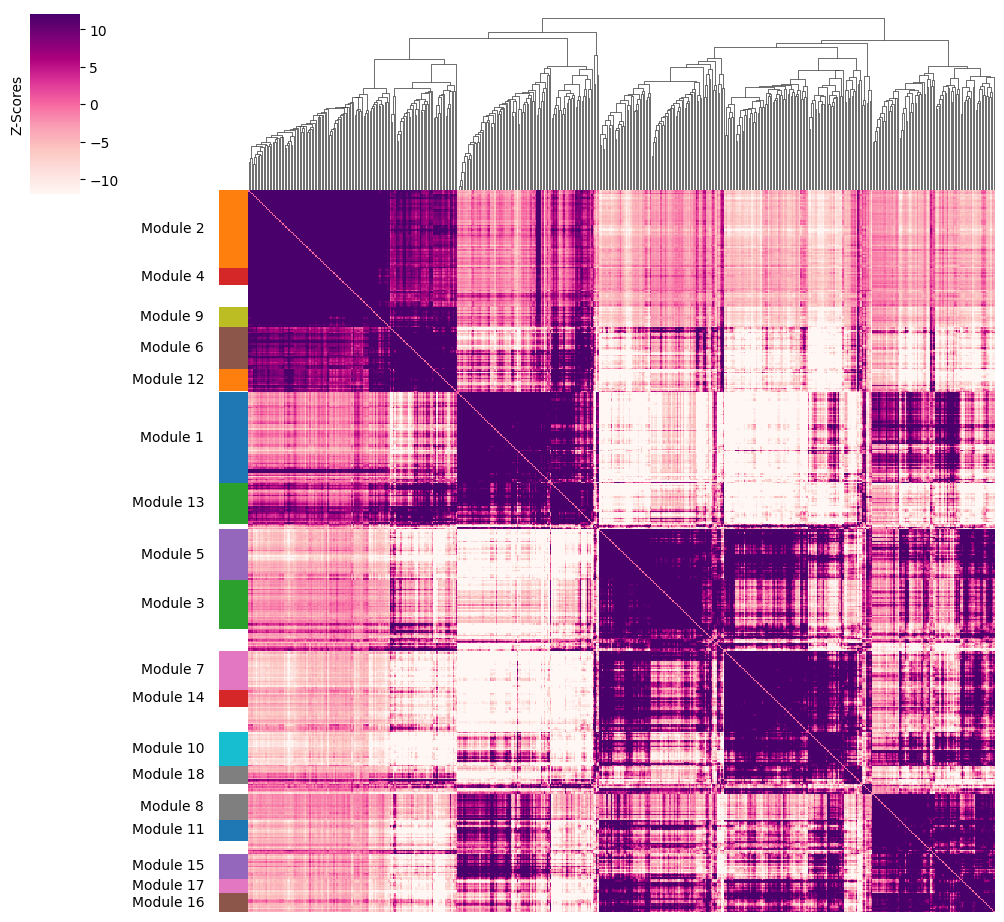

In [61]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt

with mpl.rc_context({'figure.figsize': (5, 5)}):
   fig = hs.plot_local_correlations(vmin=-12, vmax=12,z_cmap='RdPu')

plt.savefig(fname="./figures/hotspot_dpi1200_granulosa.pdf",dpi=1200, format="pdf")


In [86]:
import pandas as pd
# Show the top genes for a module

module = 16

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

results.to_csv("./figures/granulosa_module_gene/Granulosa_module16.csv",index=True,sep=',')

In [52]:
results

C           Z  Pval  FDR  Module
Gene                                                 
CCDC80        0.703214  178.625964   0.0  0.0     5.0
PNLIPRP2      0.666263  172.084829   0.0  0.0     5.0
NR2F1         0.571301  149.236763   0.0  0.0     5.0
LOC100526118  0.539926  142.863466   0.0  0.0     5.0
LOC100510917  0.507980  135.197412   0.0  0.0     5.0
FGL2          0.534713  132.303894   0.0  0.0     5.0
IGFBP7        0.723470  129.028068   0.0  0.0     5.0
DNER          0.538341  120.328857   0.0  0.0     5.0
ITPR2         0.479428  118.375830   0.0  0.0     5.0
NID2          0.465974  113.467791   0.0  0.0     5.0
MME           0.531371  110.747206   0.0  0.0     5.0
LOC100153854  0.436285  109.810328   0.0  0.0     5.0
MYL7          0.426016  109.016977   0.0  0.0     5.0
GXYLT2        0.499622  107.255158   0.0  0.0     5.0
PLPP1         0.454849  103.479464   0.0  0.0     5.0
LOC110261493  0.388260  102.119635   0.0  0.0     5.0
OLFML3        0.400191  101.027724   0.0  0.0     5.0
FRZB          0.400842   97.830025   0.0  0.0     5.0
FXYD7         0.482682   82.309145   0.0  0.0     5.0
PLTP          0.515126   76.948790   0.0  0.0     5.0
LOC100739707  0.307708   75.182372   0.0  0.0     5.0
FGFBP3        0.295881   70.604844   0.0  0.0     5.0
SCARB2        0.472484   70.023502   0.0  0.0     5.0
MMP23B        0.290236   69.276780   0.0  0.0     5.0
TMEM97        0.469059   64.730319   0.0  0.0     5.0
SLC1A4        0.290154   57.675476   0.0  0.0     5.0
FBLN2         0.300363   54.710683   0.0  0.0     5.0
ISLR          0.225124   50.965464   0.0  0.0     5.0
EMP3          0.312610   49.895719   0.0  0.0     5.0
SLC40A1       0.257643   48.501688   0.0  0.0     5.0
IGF2BP2       0.241784   47.769184   0.0  0.0     5.0
HSPG2         0.241873   47.742417   0.0  0.0     5.0
MRC2          0.258299   47.252335   0.0  0.0     5.0
LRP1          0.298035   46.392041   0.0  0.0     5.0
ARL4A         0.257342   45.665039   0.0  0.0     5.0

In [53]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 18 modules...


100%|█████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.07it/s]


1         2         3         4         5   \
E45:AAACCCAAGAGGGCGAx -4.054107 -1.311520 -1.089814 -0.452490 -0.783610   
E45:AAACCCAAGTGGCCTCx -4.156722 -1.428617  0.453108 -0.407598  5.013898   
E45:AAACCCAGTTTAAGGAx -3.838664 -1.215050 -1.084386 -0.351992 -2.070558   
E45:AAACGAAAGAGGGTGGx -4.304872 -1.361922  0.565853 -0.432783  4.306758   
E45:AAACGCTAGAAGGCTCx -4.204289 -0.887024  0.057700 -0.304741 -1.000397   

                             6         7         8         9         10  \
E45:AAACCCAAGAGGGCGAx -1.624288  3.619753 -0.835914 -0.546636  2.264755   
E45:AAACCCAAGTGGCCTCx -1.568294  4.919497 -0.484952 -0.810083  1.629982   
E45:AAACCCAGTTTAAGGAx  0.372413  0.083719 -0.815857 -0.326083 -0.381535   
E45:AAACGAAAGAGGGTGGx -1.559055  4.521822 -0.680654 -0.691884  1.220706   
E45:AAACGCTAGAAGGCTCx  1.475558  0.604172 -0.909765 -0.183546 -0.517132   

                             11        12        13        14        15  \
E45:AAACCCAAGAGGGCGAx -0.886107 -0.487370 -1.349628  0.478117 -1.320611   
E45:AAACCCAAGTGGCCTCx -0.128657 -1.136503 -1.762459  3.118539 -0.555656   
E45:AAACCCAGTTTAAGGAx -1.768216  0.654704 -0.815108 -0.611175 -1.586004   
E45:AAACGAAAGAGGGTGGx -0.127093 -1.250599 -1.826700  2.956456 -0.839273   
E45:AAACGCTAGAAGGCTCx -1.602290  0.667612 -0.733514 -0.309589 -1.587920   

                             16        17        18  
E45:AAACCCAAGAGGGCGAx -0.744209 -0.531675  3.303203  
E45:AAACCCAAGTGGCCTCx  1.383969  0.928328  0.144870  
E45:AAACCCAGTTTAAGGAx -1.164584 -1.172634  1.811717  
E45:AAACGAAAGAGGGTGGx  0.727888  0.909566  0.275374  
E45:AAACGCTAGAAGGCTCx -1.118901 -1.037201  1.504505

In [54]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

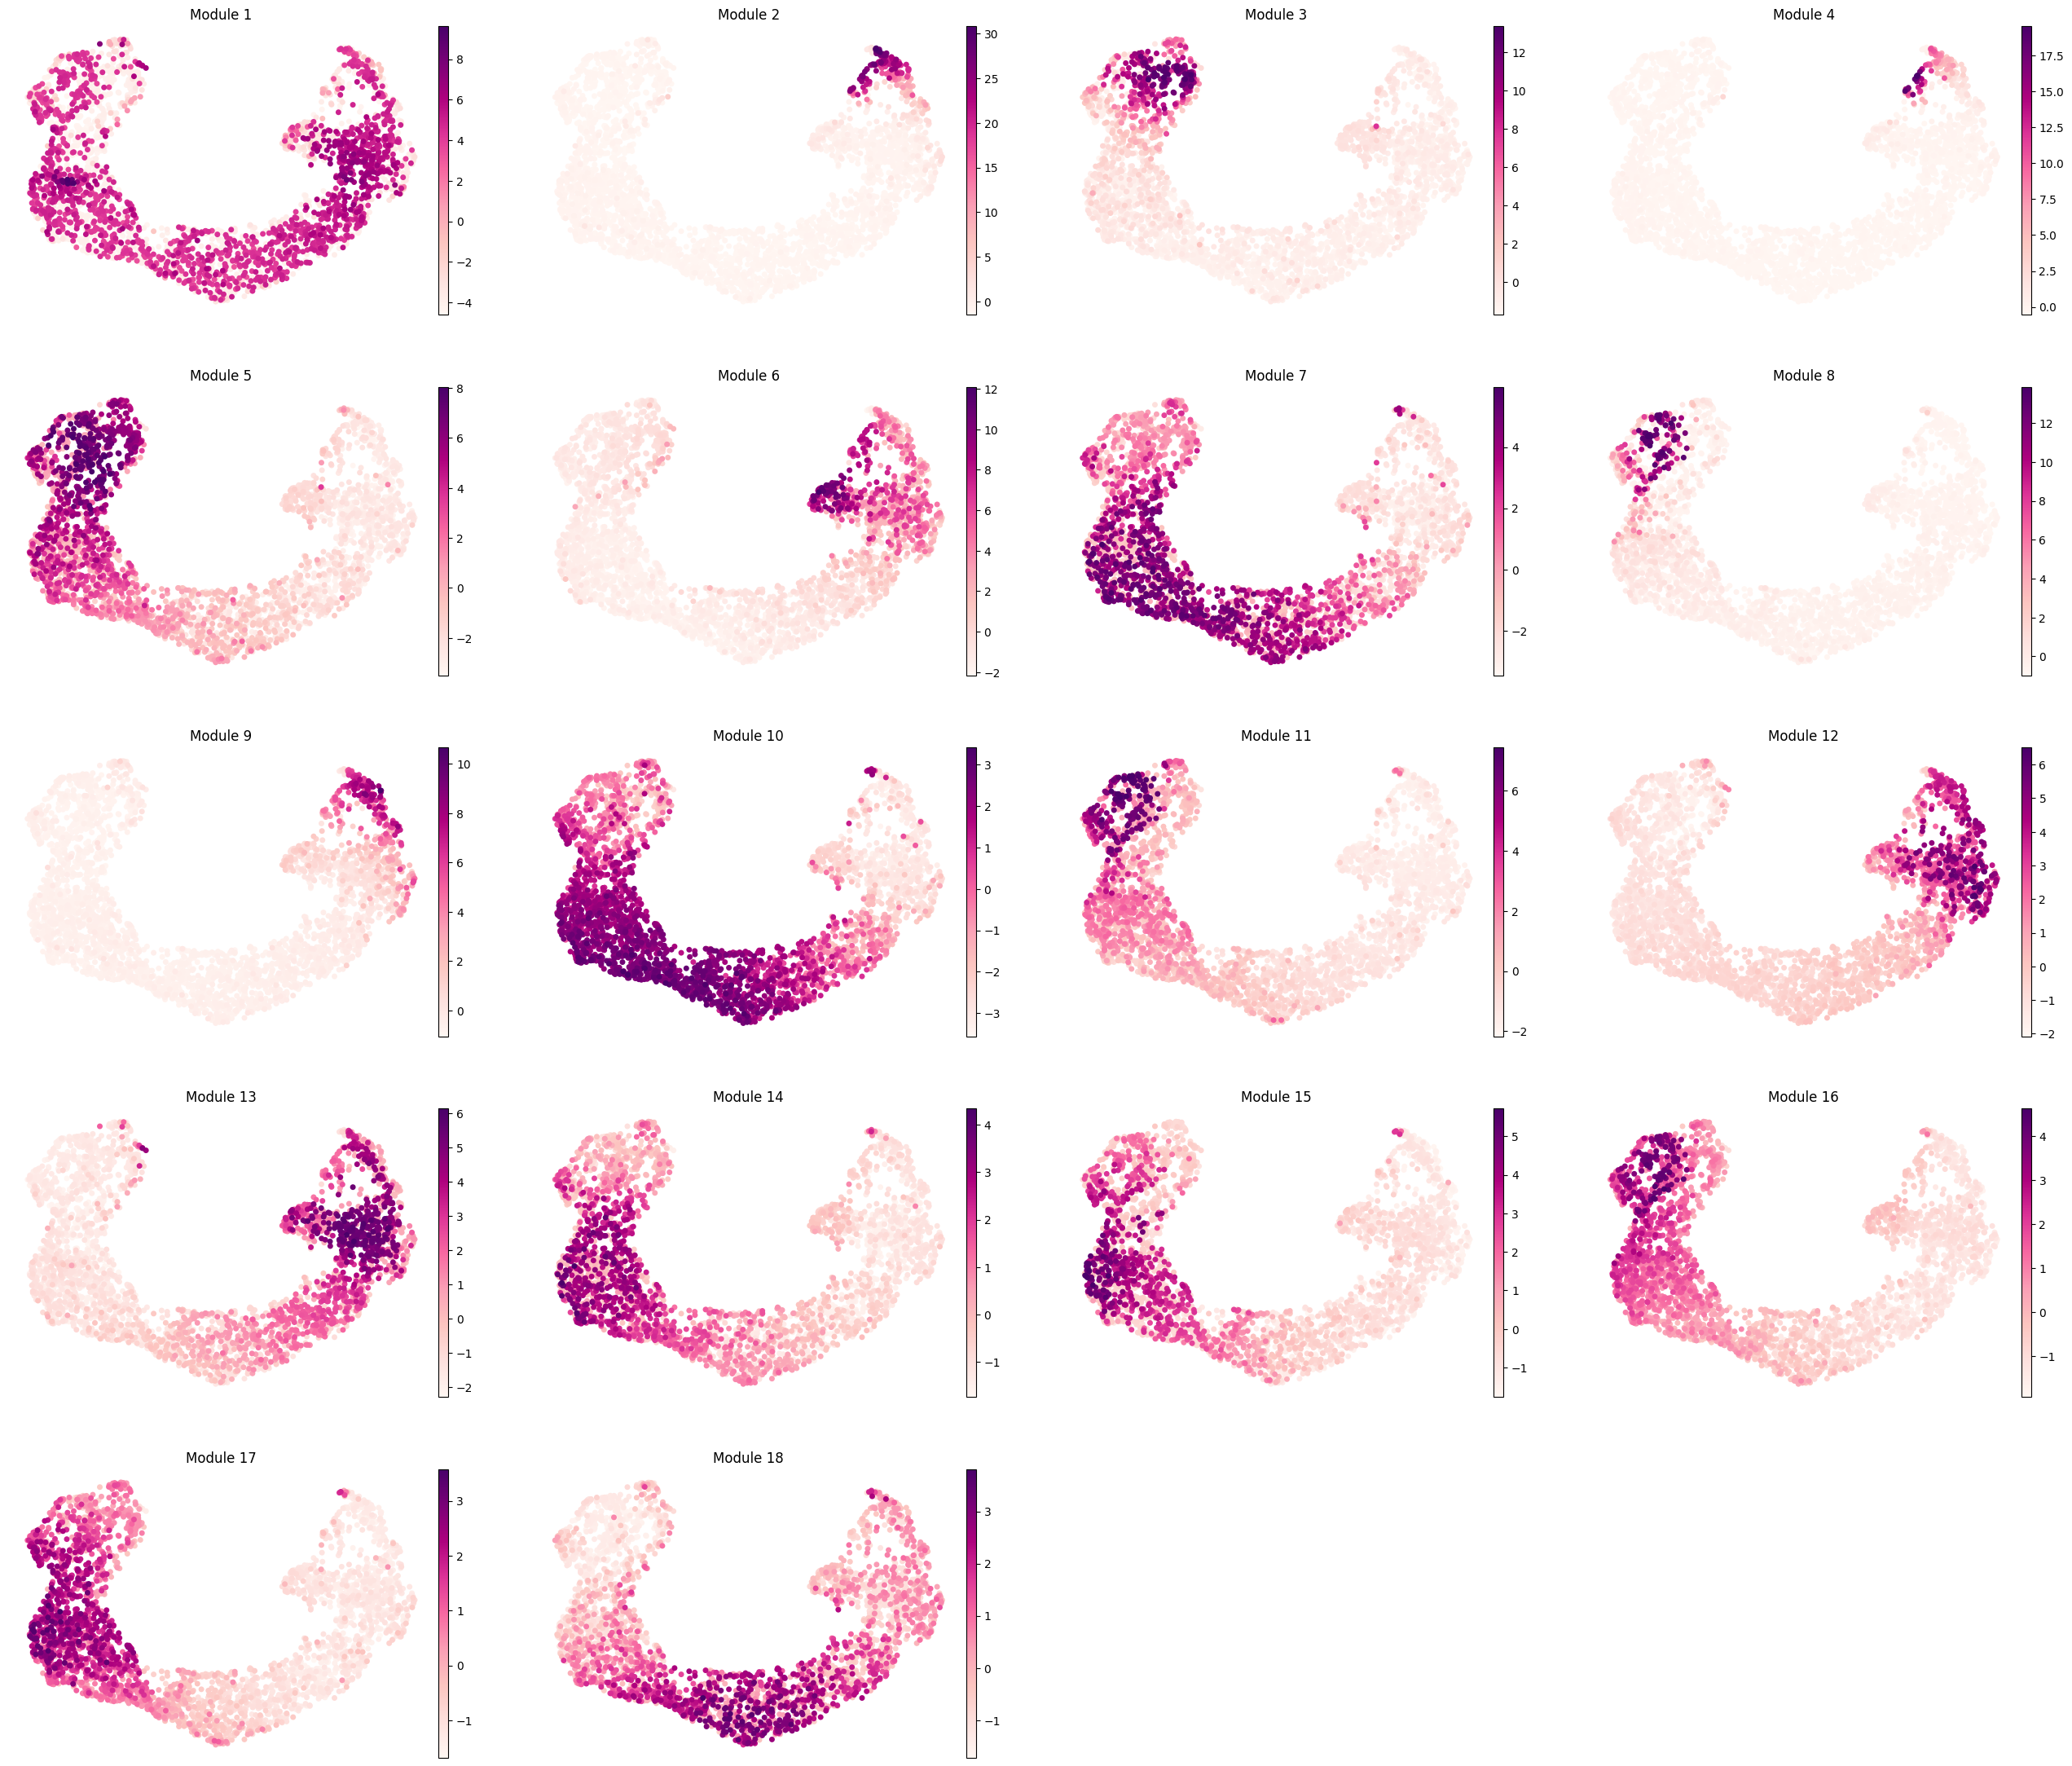

In [58]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (7, 5)}):
    fig=sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu")
#plt.savefig(fname="./figures/Module_score.pdf",dpi=1200, format="pdf")


In [63]:
module_cols

['Module 1',
 'Module 2',
 'Module 3',
 'Module 4',
 'Module 5',
 'Module 6',
 'Module 7',
 'Module 8',
 'Module 9',
 'Module 10',
 'Module 11',
 'Module 12',
 'Module 13',
 'Module 14',
 'Module 15',
 'Module 16',
 'Module 17',
 'Module 18']

In [69]:
my_module=["Module 6","Module 12","Module 13"]

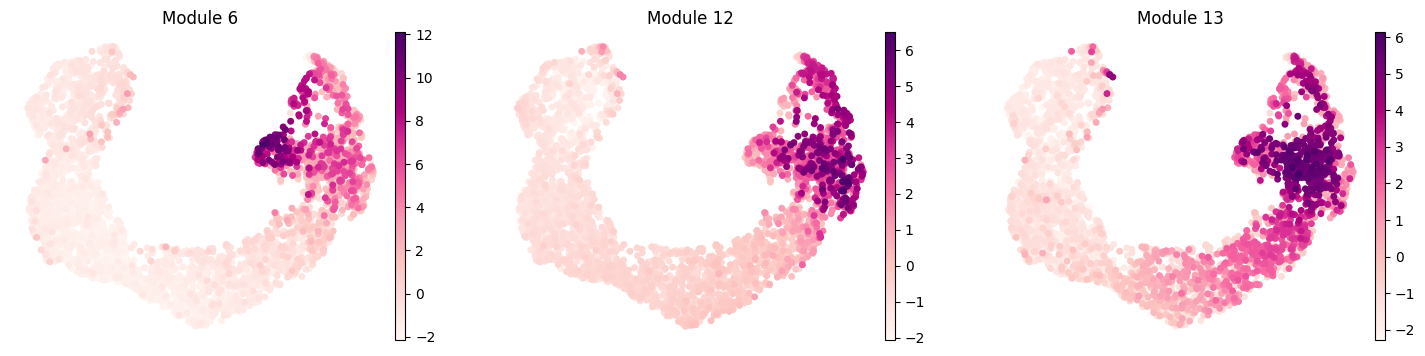

In [77]:
from matplotlib.pyplot import rc_context


#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with mpl.rc_context({'figure.figsize': (5, 4)}):
 fig = sc.pl.umap(adata, color=my_module, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu",
               save="Module_score_Granulosa_OSE.pdf"
                 )
#plt.savefig(fname="./figures/Module_score.pdf",dpi=600, format="pdf")


In [ ]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with mpl.rc_context({'figure.figsize': (8, 7)}):
 fig = sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu",
               save="Module_score_Granulosa.pdf")
#plt.savefig(fname="./figures/Module_score.pdf",dpi=600, format="pdf")


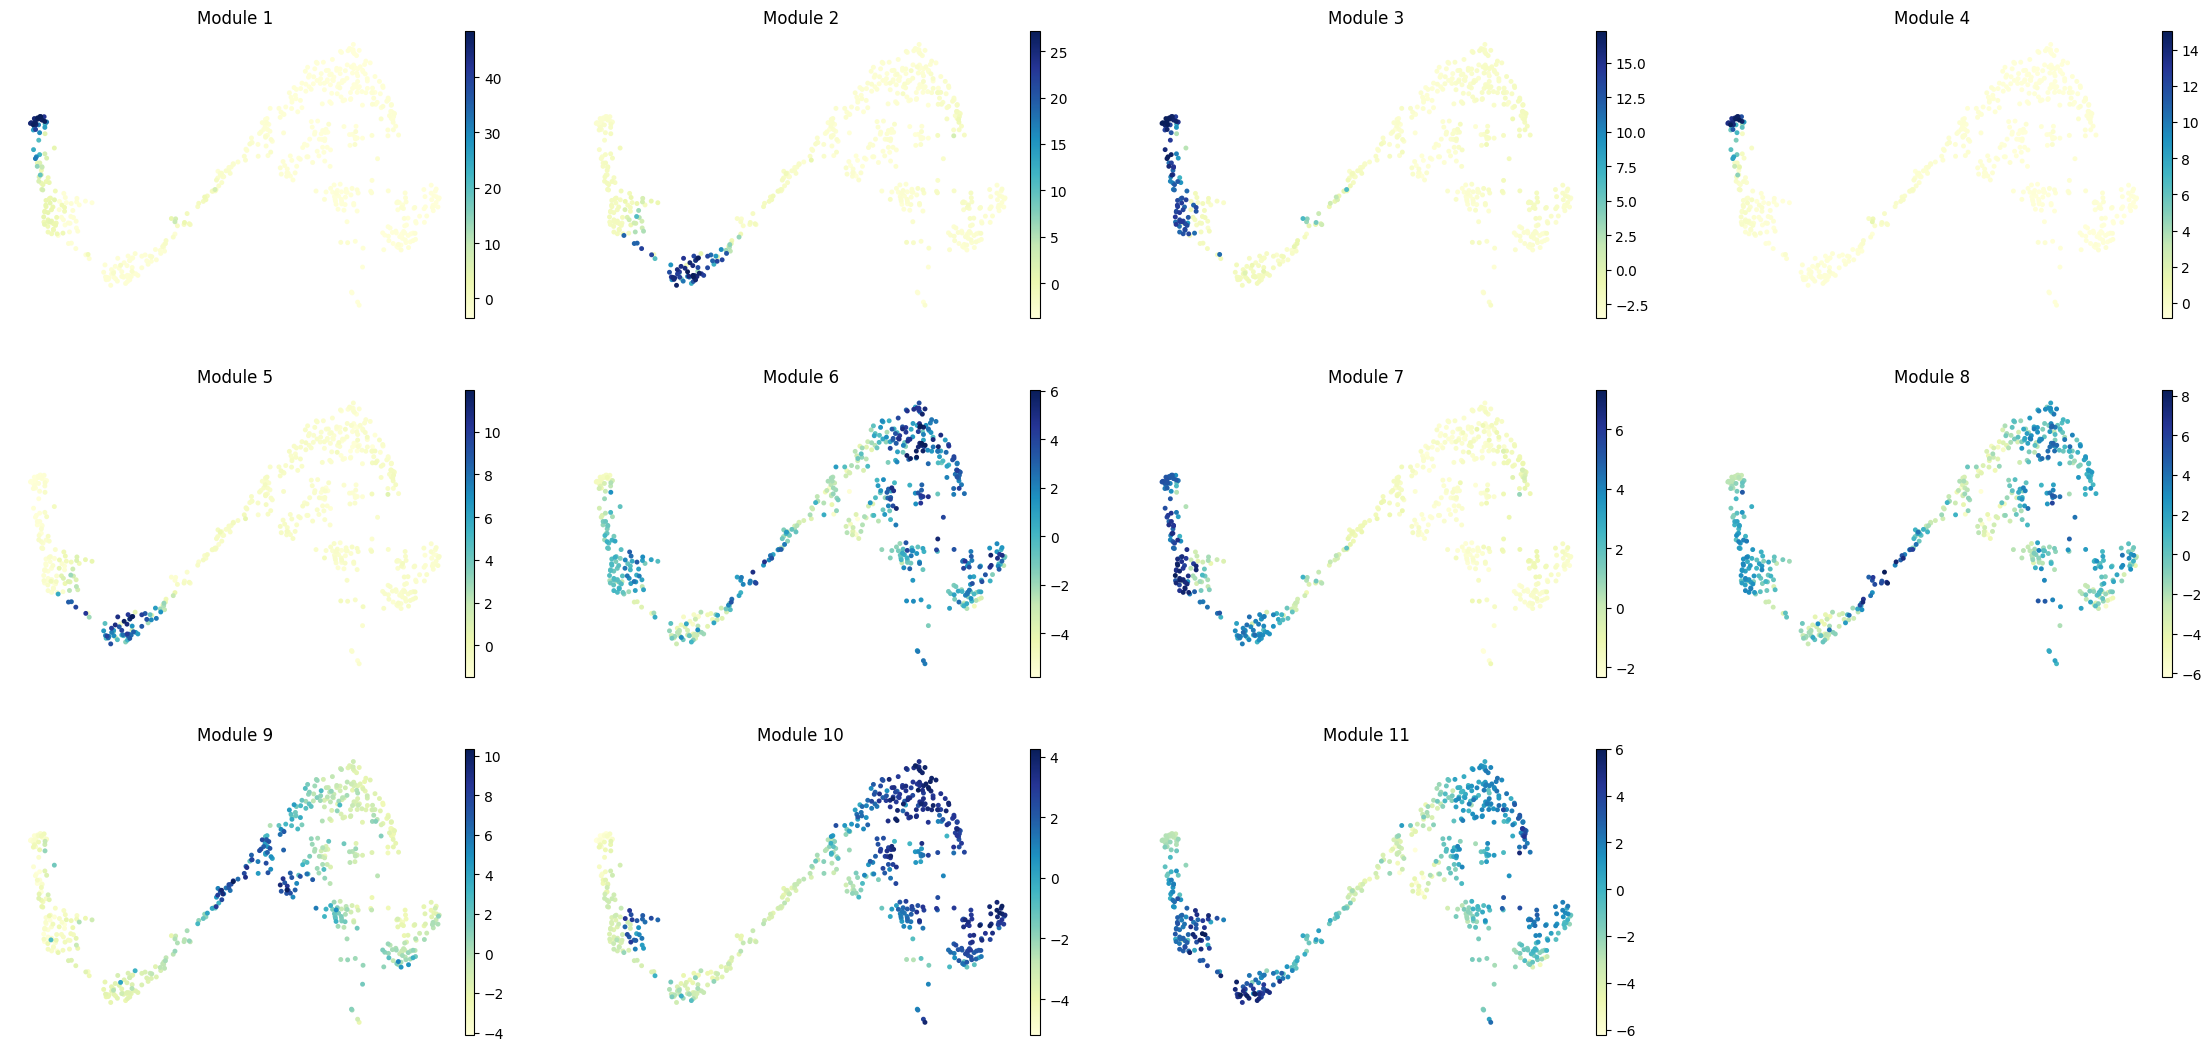

In [87]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (6, 4)}):
    sc.pl.umap(adata, color=module_cols, frameon=False, s=50, 
              # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="YlGnBu")